In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals, pool2graph_cat_FJ2_2

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Get data and fit a pool of classifiers on it

#X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult-cat')
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='boston', test_size=0.2)

print(X_train.shape, y_train.mean())
cont_names = list(set(feature_names) - set(cat_names))

(404, 13) 0.5742574257425742


In [15]:

pool1 = pool.BasicPool()
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_test)
from sklearn.metrics import f1_score
print({c: f1_score(y_test, preds[c]) for c in preds.columns})


p2g = pool2graph_cat_FJ2_2.pool2graph(X_train, y_train, pool1, k_init=300, categorical_names=cat_names)
#p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=3)

p2g.fit(max_epochs=5)#5?
print(len(p2g.G.nodes))

[11:24:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'SVMrbf': 0.9481481481481482, 'XGB': 0.9393939393939394}


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


275727


In [16]:
from discrepancies import discrepancies_intervals
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
print(len(intervals))

87905


# Global analysis of the intervals

In [6]:
%load_ext autoreload

%autoreload 2
from discrepancies import analysis_global

In [17]:
### we work with that    
gda = analysis_global.GlobalDiscrepancyAnalyzer(p2g, pool1, intervals, X_train, cat_names)

Intervals amplitude dataset (self.amplitude_dataset): shape (87905, 13)
Input data preprocessed (self.X): shape (404, 14)
Discrepancy nodes dataset (self.nodes_dataset): shape (99308, 13)
Nodes dataset (self.nodes_dataset): shape (275727, 14)


### Most problematic features

For now, we evaluate separately the uncertainty associated to each feature for continuous and categorical features.
- For continuous features: Average range of the discrepancy interval along the feature
- For categorical features: proportion of intervals generated along the feature, normalized by the exposition in Xtrain --> pas sûr qu'il faille normaliser par ça... car intercalle = 2 pts, X_train= chaque pt


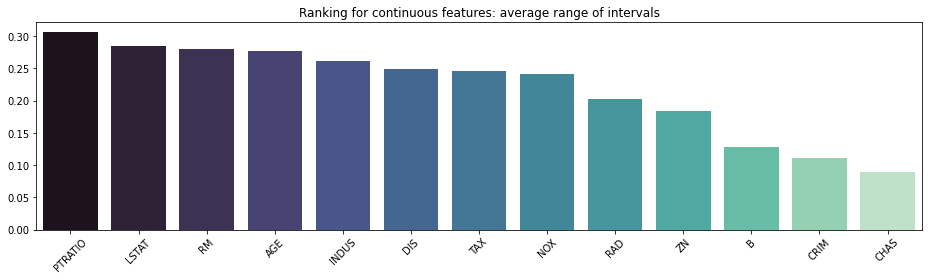

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

feat_imp = gda.get_global_discrepancy_importances(min_expo=10)
#fname = '../../results/feature_importances_adult.pdf'
gda.plot_feature_importances(palettes=['mako', 'mako'])#, savefig='')

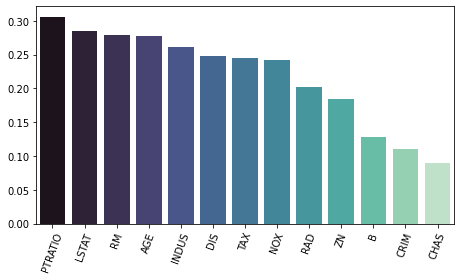

In [20]:
plt.figure(figsize=(len(feat_imp['continuous_features'])/2,4))
plt.xticks(rotation=70, fontsize=10)
sns.barplot(data=pd.DataFrame(feat_imp['continuous_features']).T, palette="mako")
#plt.title(" features")
plt.tight_layout()
#plt.savefig("./../../results/usecase_boston_featimp_cont.pdf")
plt.show()

## Important areas of discrepancy

In [51]:
%%time
gda.get_discrepancy_segments(X_exposition=X_train, y_exposition=y_train, min_expo=0.04, min_purity=0.5, min_purity_expo=0.0)

accuracy 0.6513828581361745
accuracy on given data 0.8539603960396039
====== SEGMENT 5 ======
=== Segment description:
decision node 0 : LSTAT <= 0.26860128343105316)
decision node 1 : RAD <= 0.6068322062492371)
decision node 2 : RM <= 0.3261168599128723)
decision node 3 : PTRATIO <= -0.7052654922008514)
decision node 4 : CRIM <= -0.39551956951618195)
=== Segment characteristics
Segment exposition: 0.04702970297029703
Segment node population (proxy for size?): 0.02852993687778627
Percent of the discrepancy nodes contained here: 0.014681437433681839
Segment purity: 0.5145976136075145
Segment purity (X_expo): 0.3684210526315789
Accuracy of classifiers (F1 on X_expo) on segment: {'SVMrbf': 0.36363636363636365, 'XGB': 1.0}
====== SEGMENT 25 ======
=== Segment description:
decision node 0 : LSTAT <= 0.26860128343105316)
decision node 1 : RAD > 0.6068322062492371)
=== Segment characteristics
Segment exposition: 0.06683168316831684
Segment node population (proxy for size?): 0.1597393990533478

CPU times: user 5min 2s, sys: 12.1 s, total: 5min 15s
Wall time: 4min 39s


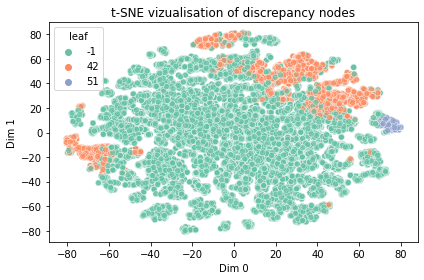

In [49]:
%%time

LEAVES_SEGMENTS = (42, 51)

data = gda.disc_nodes_dataset.sample(n=30000)
leaves_data = gda.segments_tree.apply(data)
leaves_data_rearr = np.array([ld if ld in LEAVES_SEGMENTS else -1 for ld in leaves_data])

colors = list(sns.color_palette("Set2", n_colors=len(set(leaves_data))))

from sklearn.manifold import TSNE
tsne = TSNE(perplexity=40, n_jobs=-1).fit_transform(data)
tsne = pd.DataFrame(tsne, columns=["Dim 0", "Dim 1"])
tsne['leaf'] = leaves_data_rearr
#tsne["cluster"] = clusters
sns.scatterplot(x="Dim 0", y="Dim 1", data=tsne, hue="leaf", palette="Set2", alpha=0.7)#, c=[colors[i] for i in leaves_data_rearr.values])
plt.title("t-SNE vizualisation of discrepancy nodes")
#plt.legend()
plt.tight_layout()
#plt.savefig("./../../results/discussion_tsne_boston.pdf")

<AxesSubplot:xlabel='Dim 0', ylabel='Dim 1'>

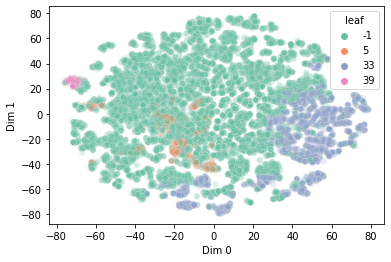

In [25]:
sns.scatterplot(x="Dim 0", y="Dim 1", data=tsne, hue="leaf", palette="Set2", alpha=0.1)#, c=[colors[i] for i in leaves_data_rearr.values])

In [45]:
gda.disc_nodes_dataset.shape

(99308, 13)

# TODO
- Categorical: quand on génère les faux jumeaux, garder en mémoire les couples des modalités: blond-brun, et le changement associé?
- TSNE: couleurs 
- relative size: devrait être nombre de noeuds de discrepancy dans la feuille sur le nombre de noeuds de discrepancy